# Project 1: predicting phenotype from genotype via regression
## Overview:
* The goal of this project is to use a regression approach to predict phenotypes from genotypes.
* Regression is any problem that makes a statistical prediction of some variable of interest (the response variable, or dependent variable) from other (independent) variables. Regressions take the form $y = f(\vec{x})$ where $y$ is the response variable and $\vec{x}$ is a vector of independent variables. The function $f$ can be anything from a simple linear model, to a decision tree, or a neural network. What you learn here is portable to these other methods with some minor changes.
* Our goal is to statistically relate gene content of bacteria to their phenotypes using a regression.  The project is based on the paper: Gowda et al. Cell (2022). https://www.cell.com/cell/pdf/S0092-8674(21)01542-7.pdf.
* As discussed in the lecture, we will be looking to predict the metabolic traits of the bacteria from their gene content. Let's briefly recall what that means.
* Below I borrow an overview figure from the paper above.


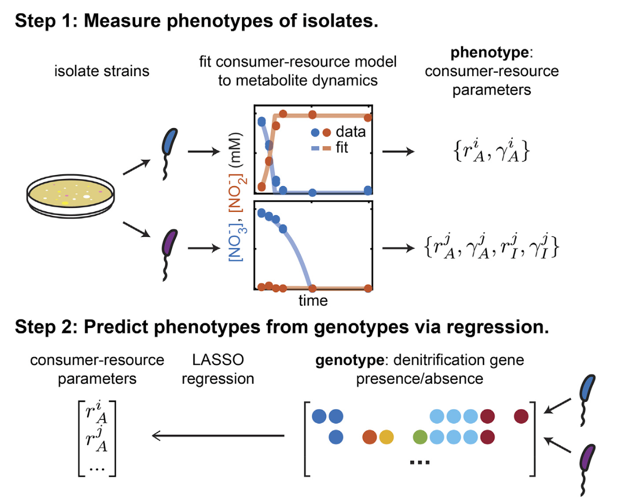

In [1]:
from IPython.display import Image
Image(filename="./KarnaOverview.png")

## Summary of approach
* First we isolated many bacterial strains from soils that perform denitrification. (utilization of nitrate/nitrite, see lecture)
* We then measured nitrate and nitrite utilization phenotypes and modeled the dynamics of that utilization (see project 3!)
* The nitrate and nitrite utilization dynamics were modeled with a consumer-resource formalism (see lecture notes).  This resulted in a set of parameters describing the rates of nitrate and nitrite utilization ($r_A$ and $r_I$ respectively) as well as biomass yields (cells/resource $\gamma_A$ and $\gamma_I$).  (Step 1)
* These four variables ($r_A$, $r_I$, $\gamma_A$, $\gamma_I$) are our response variables (we would like to predict them). We used a separate regression for each response variable.  So four regressions in total.
* (Step 2) was then to predict each of these response variables via regression using the presence and absence of genes in the pathway responsible for nitrate and nitrite utilization (denitrification).
* The regression we use is very simple, it is an additive linear model which takes this form:
$$ r_A^j = \beta_0 + \sum_i \beta_i g_{i,j} + \eta_j$$
where $r_A^j$ is the nitrate utilization rate for strain $j$.  $\beta_0$ is a constant, $g_i,j$ is a matrix with entries that are either 0 or 1 depending on if strain $j$ has gene $i$ or not.  $\beta_i$ is the coefficient that determines how the presence or absence of gene $i$ impacts the trait.  $\eta_j$ is a noise term.

**The goal of this project is to recapitulate these regressions** with the objective of understanding how to setup a regression and determine the predictive power of the model in a principled way.

## Step 1: get oriented with the data:
* The data are provided in an excel file (DataMatrix_Project1.xlsx).  You will need to write code to load that data into a pandas dataframe.  In this dataframe you have all the information you need to do the regression discussed above. Some notes on the dataframe and what the variables mean. Each row corresponds to a strain.

(1) The first column (indexed by 0 in Python!) labeled "strain" is a unique identifier for each strain in the dataset.  You can regard this as just a name.

(2) The second column (indexed by 1) is "phenotype" and is one of the three: "NAR", "NIR", or "NAR/NIR" these are strains that do the first step, second step, or both first and second steps of the denitrification cascade respectively.  See graphic at the beginning of Part 2.

(3) Columns 3-20 (index 2:19) are genes starting with NarG and ending with NarK12.  The entries of these columns are 0 if that strain does not have that gene and 1 if it does.

(4) The last four columns of the dataframe are the response variables, these are the phenotypes that we measured in the lab (above called ($r_A$, $r_I$, $\gamma_A$, $\gamma_I$), but in the dataframe they are labeled YRA, YRI, YGA, YGI with the "Y" added to indicate that they are response variables.

Let's start by getting familiar with these data, please make the following plots.

(Question 1.1, 4pts) compute the frequency of each gene across the 79 strains in the dataset. On the y-axes plot this frequency for each gene (x-axis) ranked from most frequent to least frequent.
    
(Question 1.2, 8pts) make a set of scatterplots to look at the correlation between the four response variables. To do this make a 4x4 grid of plots where the panels on the diagonals are the histograms of each response variable and the off diagonal panels are scatterplots showing each pair of response variables plotted against each other.  For example, the second panel of the first row should be a scatterplot of YRA and YRI.  Are any pairs very strongly correlated?  Correlations between phenotypes are often referred to as "trade-offs". 

Columns 3 and 4 seem to be well correlated, corresponding to response variables YGA and YGI. 

      strain phenotype  narG  napA  nirK  nirS  cnor  qnor  nosZ  narXL  ...  \
0   PAR19367   NAR/NIR     1     1     0     1     1     0     1      0  ...   
1      PDM33   NAR/NIR     1     0     1     0     1     0     1      1  ...   
2      PDM18   NAR/NIR     1     1     1     0     1     0     0      1  ...   
3      PDM20   NAR/NIR     1     0     1     0     1     0     1      1  ...   
4      PDM13       NIR     0     0     1     0     1     0     0      0  ...   
..       ...       ...   ...   ...   ...   ...   ...   ...   ...    ...  ...   
74     PDM11       NAR     0     1     0     0     0     0     0      1  ...   
75     ACV02       NAR     1     0     0     0     0     1     1      1  ...   
76     ACV01       NAR     1     0     0     1     1     1     1      1  ...   
77     CMM03   NAR/NIR     0     1     1     0     0     1     0      0  ...   
78     ACM04   NAR/NIR     1     1     1     0     0     1     1      1  ...   

    nnrU  nsrR  norR  narK1  narK2  nar

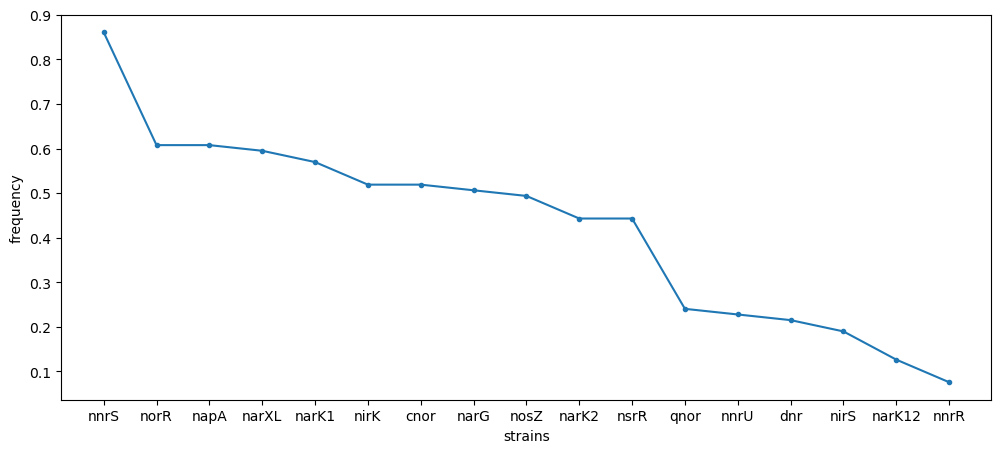

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_excel('DataMatrix_Project1.xlsx')
df_arr = df.to_numpy()
#print(df_arr.shape)
print(df)
# narG,napA,nirK,nirS,cnor,qnor,nosZ,narXL,dnr,nnrR,nnrS,nnrU,nsrR,norR,narK1,narK2,narK12
#print(df)
def colsum(col):
    return col.sum() / len(col)
data = df.iloc[:,2:19]
colsum = data.apply(colsum)
colsum_sort = colsum.sort_values(ascending=False)
#print(colsum_sort)
plt.figure(figsize=(12, 5))
plt.plot(colsum_sort, marker = '.')
plt.ylabel('frequency')
plt.xlabel('strains')

#df_index_nar = df_arr[[0,1],:]
df_indices = ['narG','napA','nirK','nirS','cnor','qnor','nosZ','narXL','dnr','nnrR','nnrS','nnrU','nsrR','norR','narK1','narK2','narK12']
#print(df_index_nar)
#df_index_nar.pivot()
#print(df_index_nar.shape)

# for col in range(2,19):
#     testcol = df_arr[:,col]
#     print(np.count_nonzero(testcol))
#     df_index_nar[1, col] = np.count_nonzero(testcol)
#print(df_index_nar)
#final_gene_arr = df_index_nar[1,2:19]
#print(final_gene_arr)
#df_sort = pd.Dataframe(final_gene_arr, columns = df_indices)
# final_gene_index = np.vstack([df_indices, final_gene_arr])
#print(final_gene_index)
# king_rayat = np.sort(final_gene_index)
# print(king_rayat)

          YRA        YRI       YGA       YGI
0   14.640954   7.069026  0.020599  0.031967
1    9.404084   9.449224  0.006193  0.010498
2   10.071433  15.250361  0.013153  0.011268
3    9.090141  13.194965  0.016234  0.019484
4    0.000000  13.412500  0.000000  0.009902
..        ...        ...       ...       ...
74  10.512211   0.000000  0.003268  0.000000
75  11.314704   0.000000  0.008224  0.000000
76   8.786990   0.000000  0.011112  0.000000
77   5.533218   4.361655  0.006917  0.010792
78   5.530593   2.738106  0.020297  0.020887

[79 rows x 4 columns]


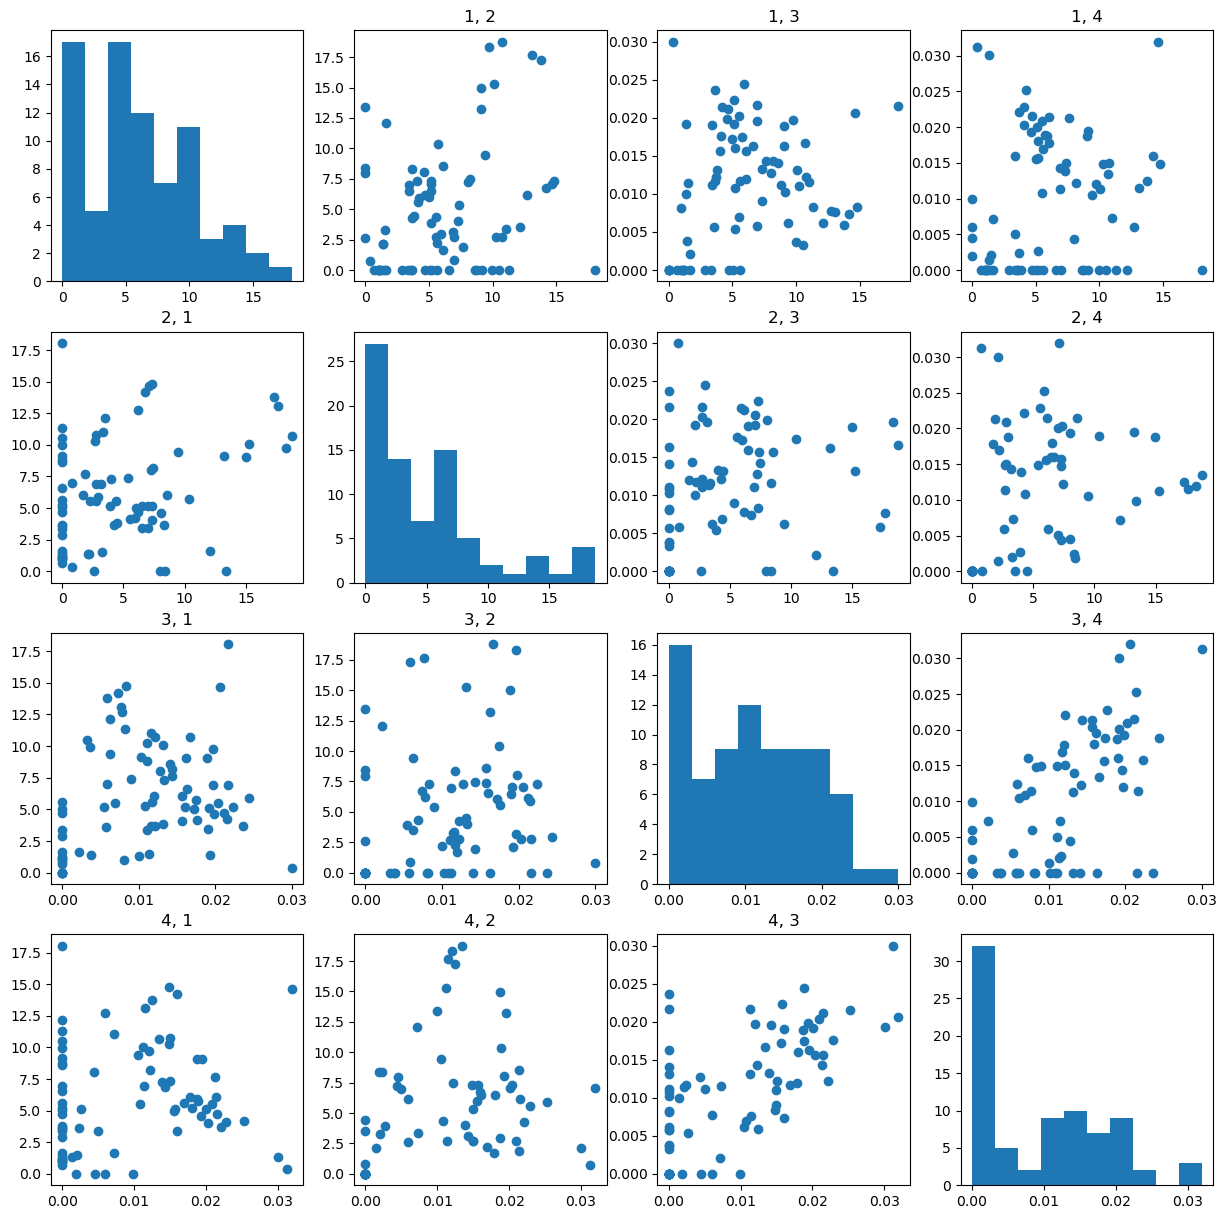

In [3]:
totalframe = df.iloc[:,19:23]
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

print(totalframe)
for col1 in range(4):
        for col2 in range(4):
            if col1 == col2:
                axes[col1,col2].hist(totalframe.iloc[:,col1])
            else:
                axes[col1,col2].scatter(totalframe.iloc[:,col1],totalframe.iloc[:,col2])
                axes[col1,col2].set_title(str(col1 +1) + ', ' + str(col2 +1 ))

## Step 2: setup the regression variables:
* As we discussed in lecture, some strains perform the first step of denitrification (NO$_3^- \rightarrow$ NO$_2^-$; Nar strains) and some perform the second step (NO$_2^- \rightarrow$ NO; Nir strains) and some perform both (Nar/Nir strains). See figure below.

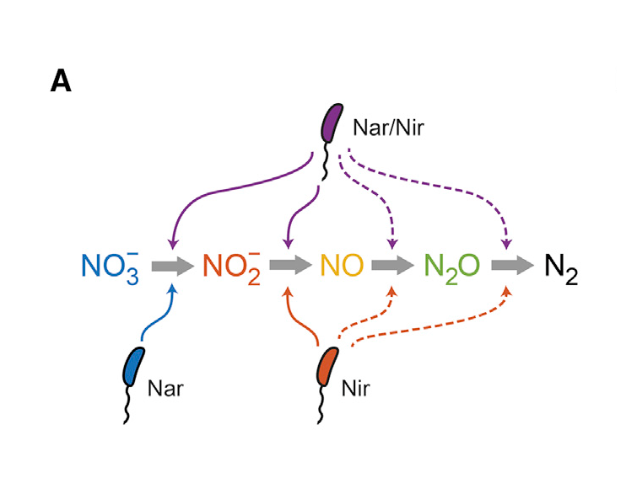

In [4]:
from IPython.display import Image
Image(filename="./NarNir.png")

* Nar only strains have response variable values for $r_A$ and $\gamma_A$ but not for $r_I$ and $\gamma_I$ and so forth. Therefore, in order to setup the regression for each of these response variables we need to pull out those strains that perform the first and second step of the cascade separately. Note, that Nar/Nir strains that perform both steps can be included in all regressions.

**Data setup** (Question 2.1 10pts) So now what we need to do is setup X and Y matrices that can be fed to the LASSO regression function to do the actual fitting. Keep in mind that the function we will call to perform the LASSO regression takes numpy arrays for the independent and dependent variables, not pandas dataframes.  So one very simple way to do this is to compute four different matrices that contain the appropriate X and Y values for each regression.  

Here is some psuedocode to give you an idea of how to do this.

1. Find all rows where the second column of the dataframe includes the string "Nar".
2. For each of those rows make a matrix XA which contains the corresponding 0 and 1 entries for all of the genes in the dataset (columns 2-19; zero indexing!). 
3. Now for those same rows construct a vector of the response variable YRA ($r_A$) which corresponds to the same rows identified in Step 1.  Same for YGA ($\gamma_A$)

Repeat the above steps to create XI and YRI and YGI which come from strains labeled "Nir" (e.g. Nar/Nir or Nir strains) -- see the graphic above!


In [2]:
#For Nar
#print(df_arr)
Nar_frame = []
Nir_frame = []
NarvYRA = []
NarvYGA = []
NirvYRI = []
NirvYGI = []
#print(df_arr)

for row in range(0,79):
    if df_arr[row][1] == 'NAR' or df_arr[row][1] == 'NAR/NIR':
        Nar_frame.append(df_arr[row, 2:19])
        NarvYRA.append(df_arr[row, 19])
        NarvYGA.append(df_arr[row, 21])

for row in range(0,79):
    if df_arr[row][1] == 'NIR' or df_arr[row][1] == 'NAR/NIR':
        Nir_frame.append(df_arr[row, 2:19])
        NirvYRI.append(df_arr[row, 20])
        NirvYGI.append(df_arr[row, 22])

print(Nir_frame)
print(NirvYGI)
#print((NarvYRA))
#print(len(NirvYRI))

[array([1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1], dtype=object), array([1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1], dtype=object), array([1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0], dtype=object), array([1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1], dtype=object), array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], dtype=object), array([1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1], dtype=object), array([0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0], dtype=object), array([1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0], dtype=object), array([1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0], dtype=object), array([1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0], dtype=object), array([1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0], dtype=object), array([1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0], dtype=object), array([1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0], dtype=object), array([1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 

# Step 3: Run the regressions

## Part 1

Question 3.1 (13 pts)

The regressions for each of the response variables are identical -- I would like you to focus on just one, the response variable YRI, which corresponds to $r_I$ above.  Complete the following questions for YRI only.
1. (5 pts) A plot fo the out-of-fold (sample) mean-squared-error (MSE) as a function of the hyperparameter ($\lambda$). You can plot the *average* MSE across folds for each value of $\lambda$.  Do this using 4-fold cross validation.  It is more complex from a coding perspective to do 'iterated' 4-fold cross validation so no need to do that for now.  Note make sure you choose a range of values for the hyperparameter that is broad enough to find the minimum in the MSE.
2. (2 pts) Report the value of the hyperparameter ($\hat{\lambda}$) where the out-of-fold MSE is the lowest.
3. (2 pts) Now run a *single* regression for $\lambda = \hat{\lambda}$ without any cross validation. 
4. (2 pts) Take the results of (3) and make a scatterplot of the measured vs. predicted values for each of the response variables. That is plot $r_A^i$ on one axis and $\beta + \sum_j \beta_j g_{ij}$ for each strain $i$.
5. (2 pts) For the regression for the response variable $r_A$ plot a barplot of the regression coefficients where the y-axis is $\beta_j$ and each gene is labeled.  Which gene matters the most for phenotypes?

It seems nirK is the most important gene for predicting the phenotypes

best alpha = 0.05190675028782829
[-6.83762240e-01  3.45885390e-01  4.71328373e+00 -8.51042040e-17
  4.65375342e+00 -0.00000000e+00 -1.23602635e+00  2.15600735e+00
 -9.90354336e-01 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.60091467e+00  1.42200579e+00  0.00000000e+00 -0.00000000e+00
  4.31751146e+00]


Text(0.5, 1.0, 'Regression coefficients for each gene')

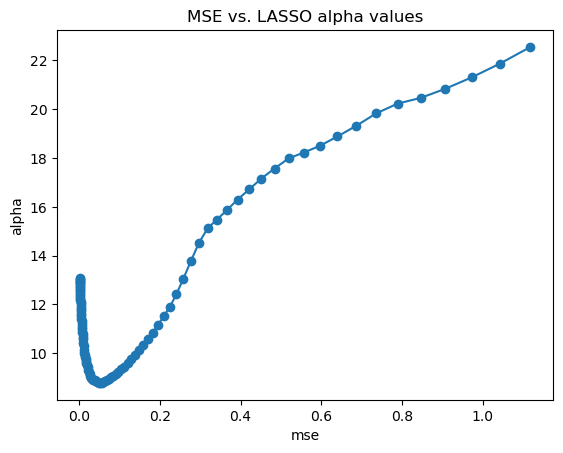

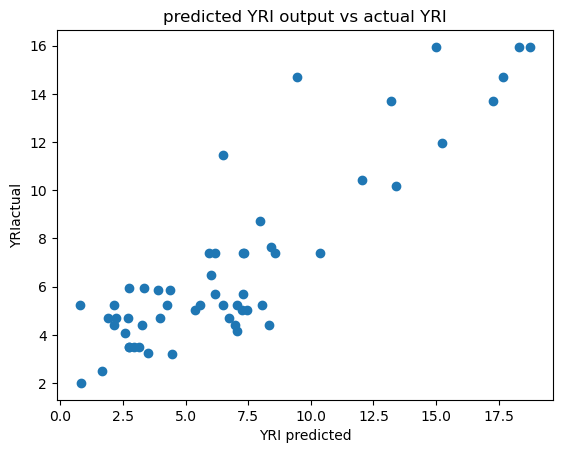

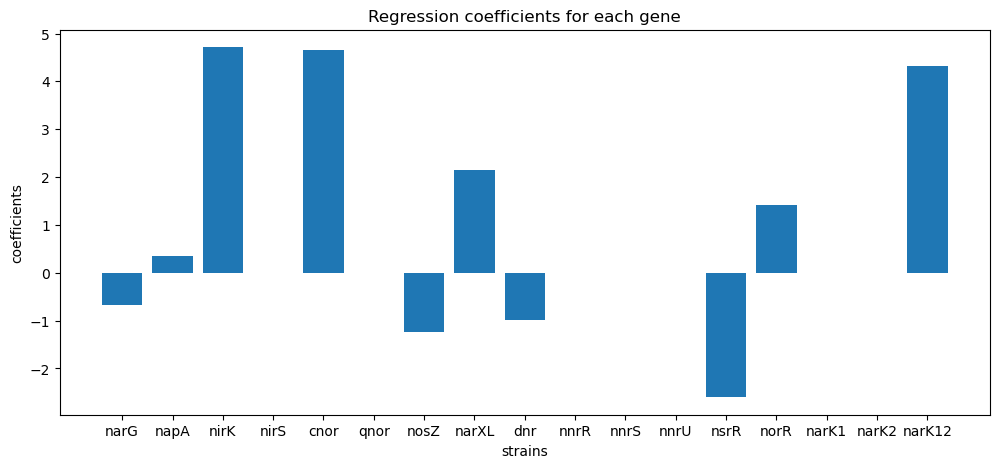

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV
from sklearn import linear_model
#Sorry this took a while, I didn't realize the background tools I needed were in Problem 6 of HW2

lassocv = LassoCV(cv=4, random_state=0)
lassocv.fit(Nir_frame, NirvYRI)
mse = lassocv.mse_path_
mseavg = np.average(mse, axis = 1)
plt.plot(lassocv.alphas_, mseavg, marker = 'o')
plt.ylabel('alpha')
plt.xlabel('mse')
plt.title('MSE vs. LASSO alpha values')
print('best alpha = ' + str(lassocv.alpha_))
alpha = lassocv.alpha_

justlasso = linear_model.Lasso(alpha=alpha)
justlasso.fit(Nir_frame, NirvYRI)
fitted = justlasso.predict(Nir_frame)
print(justlasso.coef_)

plt.figure()
plt.scatter(NirvYRI, fitted)
plt.ylabel('YRIactual')
plt.xlabel('YRI predicted')
plt.title('predicted YRI output vs actual YRI')

coefficients = lassocv.coef_
plt.figure(figsize = (12,5))
plt.bar(range(17), coefficients, tick_label = df_indices)
plt.ylabel('coefficients')
plt.xlabel('strains')
plt.title('Regression coefficients for each gene')


## Part 2

Question 3.2 (12 pts - 2 per question below) 

The way you did the regression above does not give a good picture for how the model behaves out of sample.  The reason being that we ran a single regression with all of the data at once. What I would like to actually measure is how good my regressions are out of sample. In this part of the project what you will do is assess out of sample predictive power using "leave-one-out" cross validation. To do this you will need to create a loop which does the following.  You may do this for any one of the four response variables above (but I'd recommend RI which is the one where the regressions seem to work the best).

1. Loop over every point in the dataset.  Each point in the dataset is a row of XI and the corresponding single entry of YI.
2. For each point, remove the associated row of XI and entry of YI and create a new variable with those points removed (say XIin for in sample, and YIin).  Make XIout and YIout the names of the hold out datapoint.
3. Run a LASSO regression, using cross validation again to find the best hyperparameter, on all of the data except one point.
4. After finding the optimal value of the hyperparameter, run a LASSO regression predicting YIin from XIin.
5. Use the model from 4 (regression coefficients) to predict (hatYIout) from XIout.  Save this value.
6. Loop over all datapoints.

At the end make a plot of hatYRIout vs YRIout for each datapoint (plotting all datapoints on the same panel).  How do these predictions look compared to the in-sample predictions above?  Note -- I recommend using the LassoCV function to do cross validation for Lasso:


55


/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09795460371694276, tolerance: 0.09347874169941511
  model = cd_fast.enet_coordinate_descent_gram(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09529369161700174, tolerance: 0.09347874169941511
  model = cd_fast.enet_coordinate_descent_gram(


[array([-0.08244152]), array([15.89699842]), array([9.29104764]), array([13.8839711]), array([8.48155124]), array([16.54346085]), array([7.40959279]), array([6.60057657]), array([4.77085454]), array([6.75896915]), array([4.56750444]), array([4.97043315]), array([4.54467439]), array([4.92550563]), array([4.9837998]), array([12.56806252]), array([4.90924608]), array([7.41468965]), array([15.44910721]), array([6.9332879]), array([7.59384676]), array([6.3956429]), array([5.10364345]), array([6.59637252]), array([7.63189274]), array([3.70349155]), array([4.13293748]), array([15.35194988]), array([5.20690603]), array([13.97356557]), array([7.2269633]), array([1.91706811]), array([2.76624337]), array([5.04491386]), array([5.35257737]), array([9.06052484]), array([7.26221962]), array([5.08179602]), array([4.84679557]), array([4.64785281]), array([4.49620101]), array([2.37328968]), array([5.13374171]), array([3.94695657]), array([3.55842643]), array([14.09691567]), array([3.50641973]), array([5

Text(0.5, 1.0, 'Correlation between predicted and actual YRI using leave-one-out cross validation')

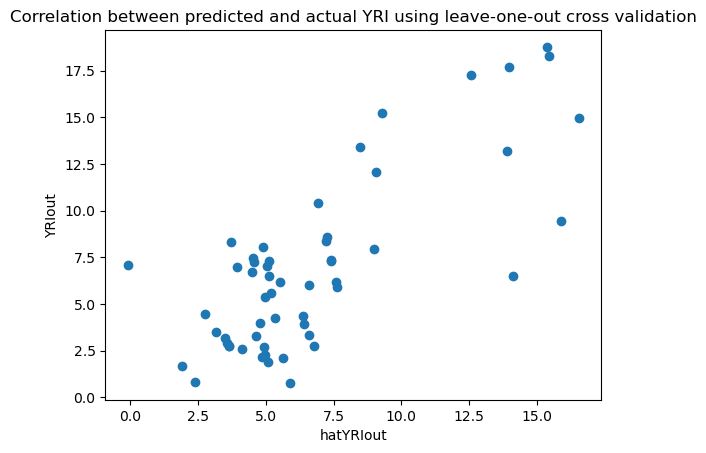

In [7]:
hatYRIout = []
#print(Nir_frame)
print(len(Nir_frame))

for row in range(len(Nir_frame)):
    XIout = Nir_frame[row]
    YIout = NirvYRI[row]
    
    leftoneoutX = np.delete(Nir_frame, (row), axis=0)
    leftoneoutY = np.delete(NirvYRI, (row), axis = 0)
    # print(leftoneoutX)
    # print(leftoneoutY)
    
    lassocv = LassoCV(cv=4, random_state=0)
    lassocv.fit(leftoneoutX, leftoneoutY)
    
    alpha = lassocv.alpha_
    justlassout = linear_model.Lasso(alpha=alpha)

    justlassout.fit(leftoneoutX, leftoneoutY)
    
    predicted = justlassout.predict(XIout.reshape(1,-1))

    hatYRIout.append(predicted)

print((hatYRIout))
plt.scatter(hatYRIout,NirvYRI)

plt.ylabel('YRIout')
plt.xlabel('hatYRIout')
plt.title('Correlation between predicted and actual YRI using leave-one-out cross validation')

Question 3.2 (2pts)
7. Make a comparison in prediction quality between the leave-one-out predictions above and the predictions you made in-sample for the same response variable in step 1.  For example, compute the R2 value for the two results independently and compare.  Which regression do you expect to be "better" in terms of these metrics and why?  Note the function from ***from sklearn.metrics import r2_score*** will be useful!

In [8]:
from sklearn.metrics import r2_score
print('leave one out')
joe = r2_score(hatYRIout,NirvYRI)
print(joe)

print('vanilla')
r2_score(fitted,NirvYRI)


leave one out
0.3734371461092675
vanilla


0.6354981229099963

## Part 3: Do the shuffle!

Question 3.3 (15 pts)

We now want to use the data to try and understand if these regressions are working well, and if so, how well?

In particular, what we want to do is ask: is the structure of the dataset that we acquired enabling these predictions?  Or is it simply that we have very few data points and a lot of independent variables?  If we had a similar dataset where we expected the regression **to fail** would it, in fact, fail?  Here is the approach:

1. Take your response variable (YRI) and **randomly shuffle** the entries of the vector (call this YRI_shuffled). What this is doing is assigning the $r_I$ value for one strain to another strain, at random. **DO NOT** shuffle the rows of the XRI matrix.  In essence, we are scrambling up the genotype to phenotype map!
2.  Now, using YRI_shuffled, perform the same leave-one-out calculation you did above. For the shuffled data, compute the same metric you computed above (R2).
3. But wait -- one shuffle is not enough!  What if we happen to find a shuffle (randomly) where the predictions work well?  What we want to assess is how good a prediction of shuffled data works **on average**. What you need to do is repeat the process above many times (30 should be ok), shuffle the data, see how good the out of sample prediction is and then **plot a histogram of your metric for many different randomizations**. x-axis is R2, y-axis is frequency of shuffles with a specific R2.
4. Is the prediction for the actual data (non-shuffled, question 7 above) better than one would expect by chance?  On the histogram you made in step 3, plot a line or arrow on the histogram from step 4.  Are the predictions on the real data better than on the shuffled data?
5. Now you are in a position to compute a p-value. Given all 30 shuffles above, what fraction of them have an R2 that is as good or better than the R2 for the unshuffled (actual) data?  This fraction is the p-value. It tells you what is the probability of observing a prediction as good or better than the actual prediction under the null hypothesis that there is no relationship between YRI and XRI.  What is the p-value you got?

The predictions on real data are much better, all the values are much lower. Since none of the shuffled values have and R2 larger than the R2 for the real data, the fraction is 0, meaning our p value is also 0. 

A couple coding hints: 
1. numpy can shuffle a vector for you with np.random.shuffle(vector goes here).  You can confirm that the shuffling is working by just plotting YRI against YRI_shuffled.
2. You may get a lot of warnings about LASSO not coverging.  Not much you can do about this -- the issue is that the regression is not working well because of the shuffle!  You can suppress these warnings via 

import warnings
warnings.filterwarnings('ignore')


3. Running 30 shuffles should take about a minute.  Why?  becuase for each shuffle you are doing N regressions where N is the number of datapoints, and for each one of those you are searching through many values of the hyperparameter, so it's a lot. Get the code running first while running just a couple of shuffles before running the whole thing!

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


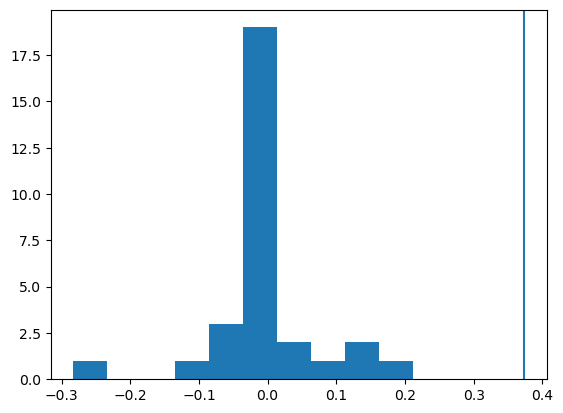

In [9]:
import random
import warnings 
warnings.filterwarnings('ignore')
#print(np.sort(NirvYRI))
#print('EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE')

def scrambler(NirvYRI):
    scrambled_YRI = []
    NirvRand = NirvYRI
    for row in range(len(NirvYRI)):
        #print(len(NirvRand))
        randindex = random.randint(0,len(NirvRand) -1 )
        #print(randindex)
        YIrandout = NirvRand[randindex]
        scrambled_YRI.append(YIrandout)
        NirvRand = np.delete(NirvRand, randindex, axis = 0)
    return scrambled_YRI
    
#print(np.sort(scrambler(NirvYRI)))

#Whoops I only just saw the np.random.shuffle coding hint

r2s = []
for shuf in range(30):
    scrambled = scrambler(NirvYRI)
    shuffledYRIout = []
    #print(Nir_frame)
    #print(scrambled)
    
    for row in range(len(Nir_frame)):
        XIout = Nir_frame[row]
        YIout = scrambled[row]
        
        leftoneoutX = np.delete(Nir_frame, (row), axis = 0)
        leftoneoutY = np.delete(scrambled, (row), axis = 0)
        
        lassocv = LassoCV(cv=4, random_state=0)
        lassocv.fit(leftoneoutX, leftoneoutY)
    
        alpha = lassocv.alpha_
        justlassout = linear_model.Lasso(alpha=alpha)

        justlassout.fit(leftoneoutX, leftoneoutY)
    
        predicted = justlassout.predict(XIout.reshape(1,-1))

        shuffledYRIout.append(predicted)
        
    joe = r2_score(hatYRIout,shuffledYRIout)
    #print(joe)
    print(shuf)
    #just to check the progress of the loop
    r2s.append(joe)

#print(r2s)
plt.hist(r2s)
plt.axvline(x=0.3734371461092675)